In [1]:
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import numpy as np
from models import unet_depthnet
import time
from argparse import Namespace
import skimage.transform as st
MAX_DEPTH = 1500
MIN_DEPTH = 300

/jaunt/users/trevor/anaconda3/envs/tfseggpu3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


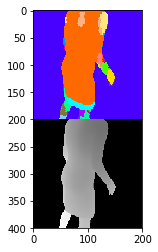

In [3]:
import matplotlib.pyplot as plt
img = plt.imread('out/unet_depthnet/imgs/test_2')
plt.imshow(img)
plt.show()

In [4]:
def get_dims(img, bg_val = 0):
    y_dim, x_dim = img.shape[:2]
    new_shape = [0,y_dim,0,x_dim]
    for i in range(y_dim):
        if np.sum(img[i,:] != bg_val) > 0:
            new_shape[0] = i
            break
    for j in range(y_dim):
        i = y_dim - j - 1
        if np.sum(img[i,:] != bg_val) > 0:
            new_shape[1] = i
            break
    for i in range(x_dim):
        if np.sum(img[:,i] != bg_val) > 0:
            new_shape[2] = i
            break
    for j in range(x_dim):
        i = x_dim - j - 1
        if np.sum(img[:,i] != bg_val) > 0:
            new_shape[3] = i
            break

    return new_shape

def crop_pad(img, x_fin, y_fin, bg_val = 0):
    cur_limits = get_dims(img, bg_val = bg_val)

    y_dim = cur_limits[1] - cur_limits[0]
    x_dim = cur_limits[3] - cur_limits[2]
    img_cropped = img[cur_limits[0]:cur_limits[1],cur_limits[2]:cur_limits[3]]

    if y_fin/x_fin >  y_dim/x_dim:  #need to pad in y_dim
        pad = int((y_fin*x_dim/x_fin - y_dim)/2)
        pad_shape = [(pad,pad),(0,0)]

    else:  #need to pad in x_dim or do no padding
        pad = int((x_fin*y_dim/y_fin - x_dim)/2)
        pad_shape = [(0,0),(pad,pad)]
    for i in range(len(img.shape)-len(pad_shape)):
        pad_shape = pad_shape + [(0,0)]

    pad_val = []
    if hasattr(bg_val, '__iter__'):
        for val in bg_val:
            pad_val = pad_val + [(val,val)]
    else:
        pad_val = bg_val
    padded = np.pad(img_cropped, pad_shape,'constant',constant_values=pad_val)

    #resize
    resized = st.resize(padded, (y_fin,x_fin),preserve_range=True)

    return resized.astype('uint8')

In [5]:
latest_checkpoint = tf.train.latest_checkpoint('experiments/unet_depthnet_small/checkpoints/best')

In [6]:
sess = tf.Session()
saver = tf.train.import_meta_graph(latest_checkpoint+'.meta')
saver.restore(sess, latest_checkpoint)

INFO:tensorflow:Restoring parameters from experiments/unet_depthnet_small/checkpoints/best/-130


In [7]:
base_path = '/jaunt/users/trevor/volcap/SyntheticData/blender/outputs/test_seq/'
file_name = 'woman_1_conversation1_6_cam.h5'
f = h5py.File(base_path+file_name, 'r')

In [8]:
frame = '0050'
cam = 1

x_batch = []
y_batch = []
for key in list(f.keys()):
    if "FRAME" in key:
        group = f[key]
        y = group['RAW/CAM1/LABEL']
        x = group['RAW/CAM1/Z']
        depth_image_scaled = np.array(x, copy=False)
        depth_image_scaled.clip(MIN_DEPTH, MAX_DEPTH, out=depth_image_scaled)
        depth_image_scaled -= MIN_DEPTH
        np.floor_divide(depth_image_scaled, (MAX_DEPTH - MIN_DEPTH + 1) / 256,
                    out=depth_image_scaled, casting='unsafe')
        final_image = crop_pad(depth_image_scaled, 125, 125, 0)
        final_image = np.expand_dims(final_image, 2)
        x_batch.append(final_image)
        y = crop_pad(y, 125, 125, 28)
        y_batch.append(y)

/jaunt/users/trevor/anaconda3/envs/tfseggpu3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
x_batch = np.array(x_batch, copy=False)


In [10]:

b_size = len(x_batch)

In [11]:
args = Namespace(abs_data_dir=None, batch_size=b_size, batchnorm_enabled=True, bias=0.0, checkpoint_best_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/checkpoints/best/', checkpoint_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/checkpoints/', config_path='unet_depthnet_train_small.yaml', data_dir='/jaunt/users/trevor/TFSegmentation/data/synthetic_seq/', data_mode='experiment', dropout_keep_prob=0.95, exp_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/', freeze_encoder=False, h5_train_file=None, h5_train_len=None, h5_val_file=None, h5_val_len=None, img_height=125, img_width=125, imgs_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/imgs/', learning_decay=1e-07, learning_decay_every=100, learning_rate=0.0001, max_to_keep=2, metrics_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/metrics/', mode='train', model='UNetDepthNet', momentum=0.9, npy_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/npy/', num_channels=1, num_classes=28, num_epochs=200, num_groups=3, operator='TrainPsy', out_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/', pretrained_path='', random_cropping=False, save_every=10, shuffle=True, summary_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/summaries/', targets_resize=None, test_every=10, tfrecord_train_file=None, tfrecord_train_len=None, tfrecord_val_file=None, tfrecord_val_len=None, train_data_len=2000, verbose=False, weight_decay=0.0005, weighted_loss=False, yaml_name=None)
model = unet_depthnet.UNetDepthNet(args)
model.build()




Building the MODEL...
Building the DepthNet..
Layer_name: mobilenet_encoder/conv_1/cond/Merge -Output_Shape: [79, 63, 63, 32]
Layer_name: mobilenet_encoder/conv_2_1/pointwise/cond/Merge -Output_Shape: [79, 63, 63, 64]
Layer_name: mobilenet_encoder/conv_2_2/pointwise/cond/Merge -Output_Shape: [79, 32, 32, 128]
Layer_name: mobilenet_encoder/conv_3_1/pointwise/cond/Merge -Output_Shape: [79, 32, 32, 128]
Layer_name: mobilenet_encoder/conv_3_2/pointwise/cond/Merge -Output_Shape: [79, 16, 16, 256]
Layer_name: mobilenet_encoder/conv_4_1/pointwise/cond/Merge -Output_Shape: [79, 16, 16, 256]
Layer_name: mobilenet_encoder/conv_4_2/pointwise/cond/Merge -Output_Shape: [79, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_1/pointwise/cond/Merge -Output_Shape: [79, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_2/pointwise/cond/Merge -Output_Shape: [79, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_3/pointwise/cond/Merge -Output_Shape: [79, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_4/pointw

In [12]:
feed_dict = {model.x_pl: x_batch,
             model.y_pl: y_batch,
             model.is_training: False
             }

In [13]:
init_op = tf.global_variables_initializer() 
sess.run(init_op)


In [14]:
a = time.time()
out_argmax, segmented_imgs = sess.run(
                [model.out_argmax,
                 model.segmented_summary],
                feed_dict=feed_dict)
b = time.time()
print(b-a)

1.5179955959320068


In [19]:
plt.imshow(segmented_imgs[3])
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

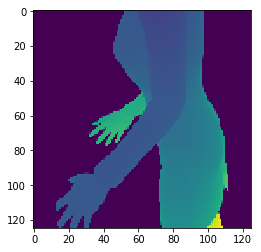

In [22]:
plt.imshow(x_batch[2][:,:,0])
plt.show()

In [24]:
np.unique(x_batch[2])

array([  0,   1,   2,   3,   4,   5,   6,   8,  10,  12,  13,  15,  16,
        19,  20,  22,  25,  26,  28,  30,  32,  33,  34,  35,  36,  38,
        39,  40,  41,  43,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 177, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 227, 228, 230, 233], dtype=uint8

In [76]:
a.shape

(79, 125, 125)